# Paleoclimate Data Processing

This notebook processes paleoclimate data and aligns it with demographic timelines.

## Steps:
1. Load occurrence data
2. Download/Load climate data
3. Extract climate data for occurrence points
4. Align climate data with PSMC time scale
5. Create climate time series


In [40]:
import geopandas as gpd

# Load the first few rows to inspect the structure
mammals_part1 = gpd.read_file("/Users/divyadhole/Capstone-project/data/MAMMALS/MAMMALS_PART1.shp")
print("Columns in MAMMALS_PART1.shp:")
print(mammals_part1.columns.tolist())

# Check the first few rows to see the species name column
print("\nFirst few rows:")
print(mammals_part1[['binomial', 'sci_name', 'species', 'name']].head() if 'binomial' in mammals_part1.columns else mammals_part1.head())

Columns in MAMMALS_PART1.shp:
['id_no', 'sci_name', 'presence', 'origin', 'seasonal', 'compiler', 'yrcompiled', 'citation', 'subspecies', 'subpop', 'source', 'island', 'tax_comm', 'dist_comm', 'generalisd', 'legend', 'kingdom', 'phylum', 'class', 'order_', 'family', 'genus', 'category', 'marine', 'terrestria', 'freshwater', 'SHAPE_Leng', 'SHAPE_Area', 'geometry']

First few rows:
   id_no              sci_name  presence  origin  seasonal  \
0     18  Abrocoma boliviensis         1       1         1   
1    138      Acerodon humilis         1       1         1   
2    139      Acerodon jubatus         1       1         1   
3    139      Acerodon jubatus         1       1         1   
4    139      Acerodon jubatus         1       1         1   

                                 compiler  yrcompiled  \
0  IUCN SSC Small Mammal Specialist Group        2016   
1                                    IUCN        2008   
2                                    IUCN        2008   
3               

### Step 1: Import required libraries and load configuration

In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import rasterio
from rasterio.transform import from_bounds
import geopandas as gpd
from pathlib import Path
import yaml
from IPython.display import display
import warnings
warnings.filterwarnings('ignore')
# Load configuration
with open('config.yaml', 'r') as f:
    config = yaml.safe_load(f)

# Set up directories
DATA_DIR = Path(config['data_dir'])
OUTPUT_DIR = Path(config['output_dir'])
OUTPUT_DIR.mkdir(exist_ok=True, parents=True)

print(f"Data directory: {DATA_DIR}")
print(f"Output directory: {OUTPUT_DIR}")

Data directory: data
Output directory: outputs


### Step 2: Download GBIF occurrence data

In [49]:

from pygbif import occurrences as gbif_occ

metadata = pd.read_excel(DATA_DIR / "metadata.xlsx")
species_list = (metadata['GENUS'].str.strip() + ' ' + metadata['SPECIES'].str.strip()).dropna().unique()

records = []
for species in species_list:
    resp = gbif_occ.search(scientificName=species, has_coordinate=True, limit=300)
    for rec in resp.get("results", []):
        lat = rec.get("decimalLatitude")
        lon = rec.get("decimalLongitude")
        if lat is None or lon is None:
            continue
        records.append({
            "scientific_name": species,
            "latitude": lat,
            "longitude": lon,
            "eventDate": rec.get("eventDate"),
            "basisOfRecord": rec.get("basisOfRecord"),
            "country": rec.get("country"),
            "gbif_id": rec.get("key")
        })

# Create and save the original occurrences DataFrame
occurrences_gbif = pd.DataFrame(records).drop_duplicates(subset=["scientific_name", "latitude", "longitude"])
occurrence_csv = OUTPUT_DIR / "occurrence_points_gbif.csv"
occurrences_gbif.to_csv(occurrence_csv, index=False)
print(f"Saved {len(occurrences_gbif)} records to {occurrence_csv}")

if occurrence_csv.exists():
    print(f"Columns: {occurrences_gbif.columns.tolist()}")
    print("\nHead:")
    display(occurrences_gbif.head())
    print("\nTail:")
    display(occurrences_gbif.tail())
else:
    print("Occurrence CSV missing—run the GBIF download cell first.")


Saved 1707 records to outputs/occurrence_points_gbif.csv
Columns: ['scientific_name', 'latitude', 'longitude', 'eventDate', 'basisOfRecord', 'country', 'gbif_id']

Head:


,scientific_name,latitude,longitude,eventDate,basisOfRecord,country,gbif_id
0,Semnopithecus entellus,24.356754,70.755160,2025-01-01T15:48,HUMAN_OBSERVATION,Pakistan,5036803148
1,Semnopithecus entellus,26.034595,76.464220,2025-01-20T08:57:13,HUMAN_OBSERVATION,India,5063191048
2,Semnopithecus entellus,26.352505,73.035316,2025-01-15T17:54:23,HUMAN_OBSERVATION,India,5063206506
3,Semnopithecus entellus,20.612318,79.868953,2025-01-13T08:26,HUMAN_OBSERVATION,India,5063235352
4,Semnopithecus entellus,20.612181,79.869096,2025-01-12T11:13:10,HUMAN_OBSERVATION,India,5063308084



Tail:


,scientific_name,latitude,longitude,eventDate,basisOfRecord,country,gbif_id
1889,Trachypithecus pileatus,27.318687,91.138344,2015-04-01,HUMAN_OBSERVATION,Bhutan,4516691887
1890,Trachypithecus pileatus,27.311541,91.113488,2015-04-01,HUMAN_OBSERVATION,Bhutan,4516696944
1891,Trachypithecus pileatus,26.782673,91.148574,2015-05-02T19:56,HUMAN_OBSERVATION,India,1500313101
1892,Trachypithecus pileatus,26.632312,94.347208,2015-05-08,HUMAN_OBSERVATION,India,1571057114
1893,Trachypithecus pileatus,26.917725,92.872184,2015-08-23T16:41,HUMAN_OBSERVATION,India,3802576178


### Step 3: Species Range Validation

In [50]:

# Step 3: Species Range Validation
def validate_species_range(occurrences_df, mammals_dir):
    """
    Filter occurrence points to only include those within the species' known range.
    """
    import os
    from shapely.geometry import Point
    
    # Create a copy to avoid modifying the original
    validated_occurrences = []
    
    # Print total number of points before validation
    print(f"Total points before validation: {len(occurrences_df)}")
    
    # Define the shapefile paths
    shapefile_paths = [
        os.path.join(mammals_dir, "MAMMALS_PART1.shp"),
        os.path.join(mammals_dir, "MAMMALS_PART2.shp")
    ]
    
    # Load both shapefiles
    try:
        mammals_gdf = gpd.GeoDataFrame(pd.concat(
            [gpd.read_file(shp) for shp in shapefile_paths],
            ignore_index=True
        ))
        print("Successfully loaded IUCN mammals range data")
    except Exception as e:
        print(f"Error loading shapefiles: {str(e)}")
        return pd.DataFrame()
    
    # Function to clean and standardize species names
    def clean_species_name(name):
        if pd.isna(name):
            return ""
        return str(name).strip().lower()
    
    # Clean the species names in both dataframes for matching
    mammals_gdf['sci_name_clean'] = mammals_gdf['sci_name'].apply(clean_species_name)
    
    # Process each species
    for species_name, group in occurrences_df.groupby('scientific_name'):
        try:
            clean_name = clean_species_name(species_name)
            print(f"\nProcessing: {species_name} (clean: {clean_name})")
            
            # Find the species in the mammals shapefile
            species_range = mammals_gdf[mammals_gdf['sci_name_clean'] == clean_name]
            
            if species_range.empty:
                print(f"  No exact match found. Searching for similar names...")
                similar = mammals_gdf[mammals_gdf['sci_name_clean'].str.contains(clean_name.split()[0])]
                if not similar.empty:
                    print(f"  Found similar species: {similar['sci_name'].unique()}")
                continue
                
            print(f"  Found range data for {species_name}")
            
            # Convert occurrence points to GeoDataFrame
            geometry = [Point(xy) for xy in zip(group['longitude'], group['latitude'])]
            points_gdf = gpd.GeoDataFrame(group, geometry=geometry, crs=species_range.crs)
            
            # Spatial join to find points within the range
            points_in_range = gpd.sjoin(
                points_gdf, 
                species_range, 
                how='inner', 
                predicate='within'
            )
            
            if not points_in_range.empty:
                # Keep only the original columns
                points_in_range = points_in_range[group.columns]
                validated_occurrences.append(points_in_range)
                print(f"  Found {len(points_in_range)}/{len(group)} points within range")
            else:
                print(f"  No points within range for {species_name}")
                
        except Exception as e:
            print(f"Error processing {species_name}: {str(e)}")
            continue
    
    if not validated_occurrences:
        print("\nNo valid occurrence points found within species ranges")
        return pd.DataFrame()
    
    # Combine all validated occurrences
    validated_df = pd.concat(validated_occurrences, ignore_index=True)
    
    # Drop any duplicate points that might have been created
    validated_df = validated_df.drop_duplicates(subset=['scientific_name', 'latitude', 'longitude'])
    
    print(f"\nValidation complete. Kept {len(validated_df)} out of {len(occurrences_df)} points.")
    return validated_df

# Run the validation
print("\nStarting species range validation...")
validated_occurrences = validate_species_range(occurrences_gbif, str(DATA_DIR / "MAMMALS"))

if not validated_occurrences.empty:
    # Save the validated occurrences
    validated_csv = OUTPUT_DIR / "validated_occurrences.csv"
    validated_occurrences.to_csv(validated_csv, index=False)
    print(f"\nSaved {len(validated_occurrences)} validated occurrence points to {validated_csv}")
    
    # Update the occurrences_gbif variable to use only validated points
    occurrences_gbif = validated_occurrences
    print("Updated 'occurrences_gbif' with validated points only")
else:
    print("\nNo valid occurrences found within species ranges, using all GBIF points")



Starting species range validation...
Total points before validation: 1707
Successfully loaded IUCN mammals range data

Processing: Semnopithecus entellus (clean: semnopithecus entellus)
  Found range data for Semnopithecus entellus
  Found 65/268 points within range

Processing: Semnopithecus hypoleucos (clean: semnopithecus hypoleucos)
  Found range data for Semnopithecus hypoleucos
  Found 157/262 points within range

Processing: Semnopithecus johnii (clean: semnopithecus johnii)
  Found range data for Semnopithecus johnii
  Found 285/300 points within range

Processing: Semnopithecus schistaceus (clean: semnopithecus schistaceus)
  Found range data for Semnopithecus schistaceus
  Found 172/268 points within range

Processing: Trachypithecus geei (clean: trachypithecus geei)
  Found range data for Trachypithecus geei
  Found 82/149 points within range

Processing: Trachypithecus phayrei (clean: trachypithecus phayrei)
  Found range data for Trachypithecus phayrei
  Found 127/162 poi

### Step 4: Visualize Original vs Validated Points


Generating validation plots for each species...
Saved validation plot for Semnopithecus entellus to outputs/validation_Semnopithecus_entellus.png


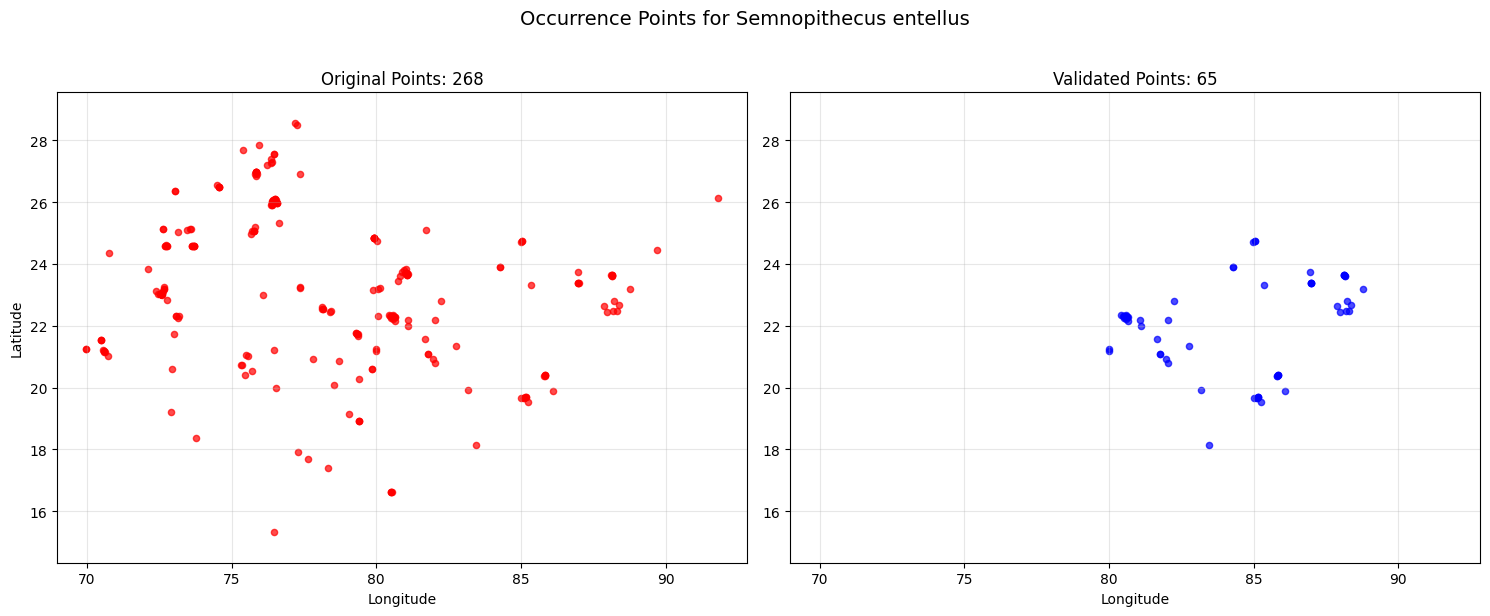

Saved validation plot for Semnopithecus hypoleucos to outputs/validation_Semnopithecus_hypoleucos.png


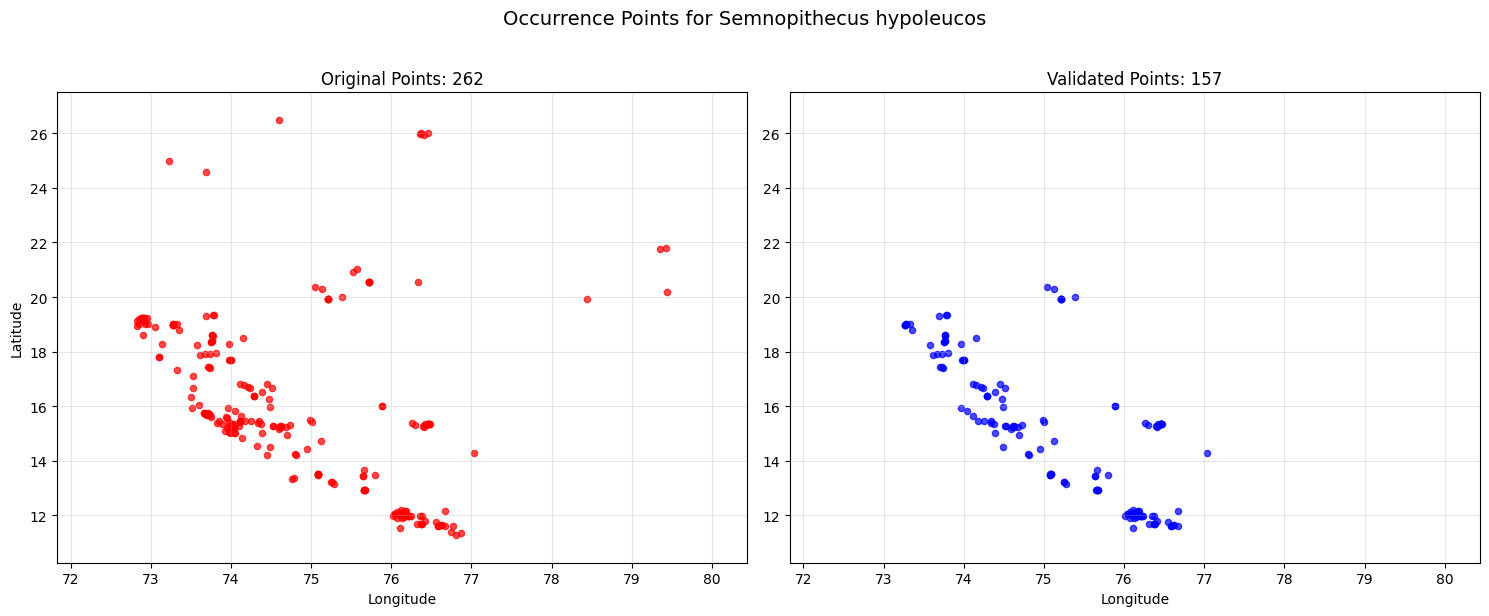

Saved validation plot for Semnopithecus johnii to outputs/validation_Semnopithecus_johnii.png


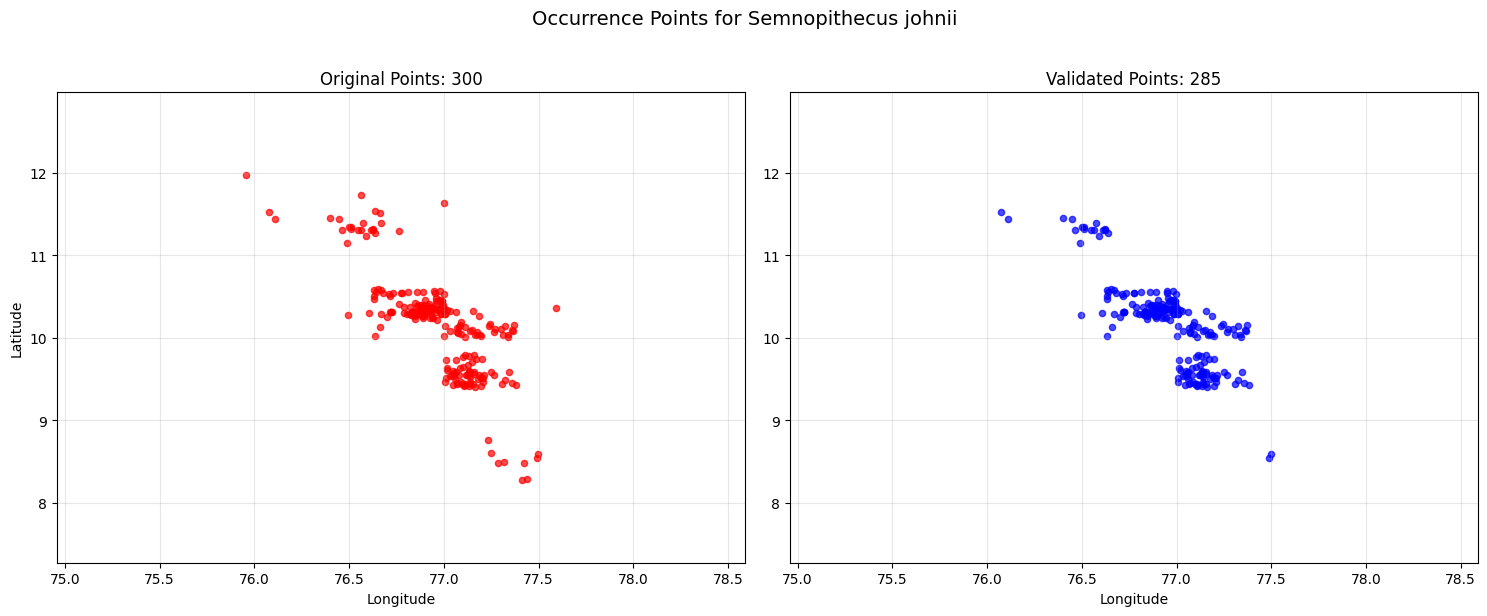

Saved validation plot for Semnopithecus schistaceus to outputs/validation_Semnopithecus_schistaceus.png


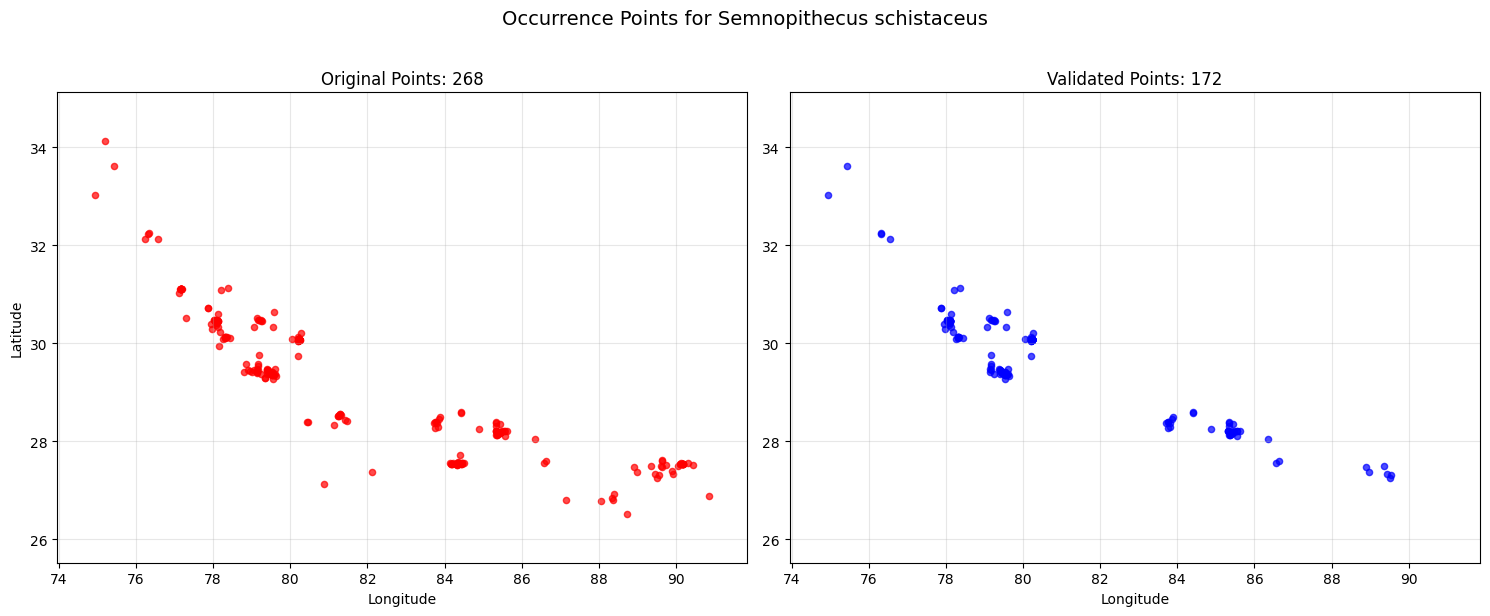

Saved validation plot for Trachypithecus geei to outputs/validation_Trachypithecus_geei.png


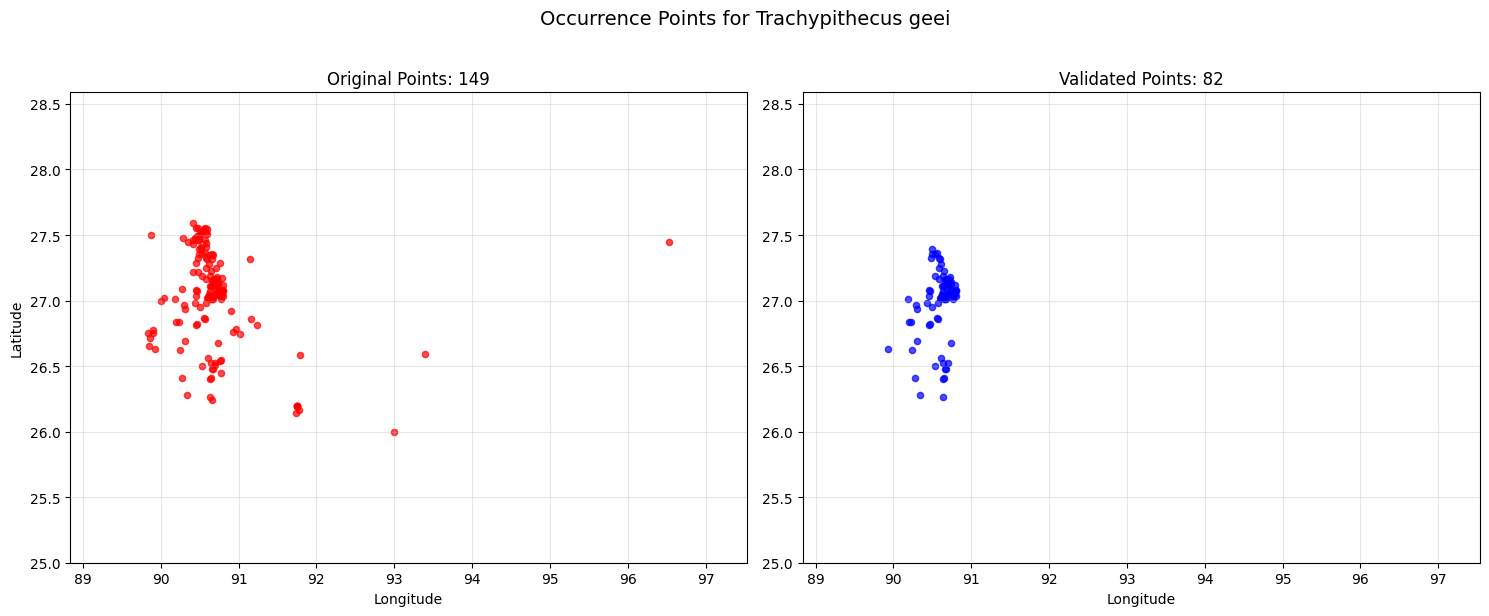

Saved validation plot for Trachypithecus phayrei to outputs/validation_Trachypithecus_phayrei.png


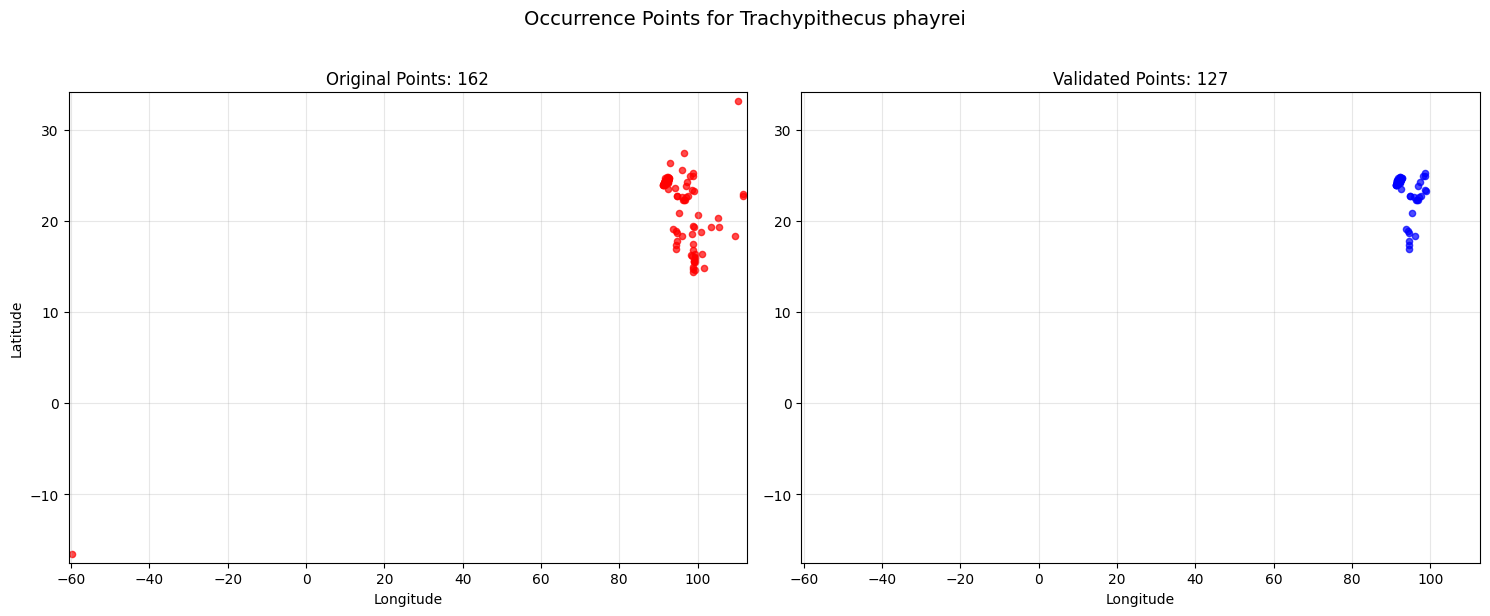

Saved validation plot for Trachypithecus pileatus to outputs/validation_Trachypithecus_pileatus.png


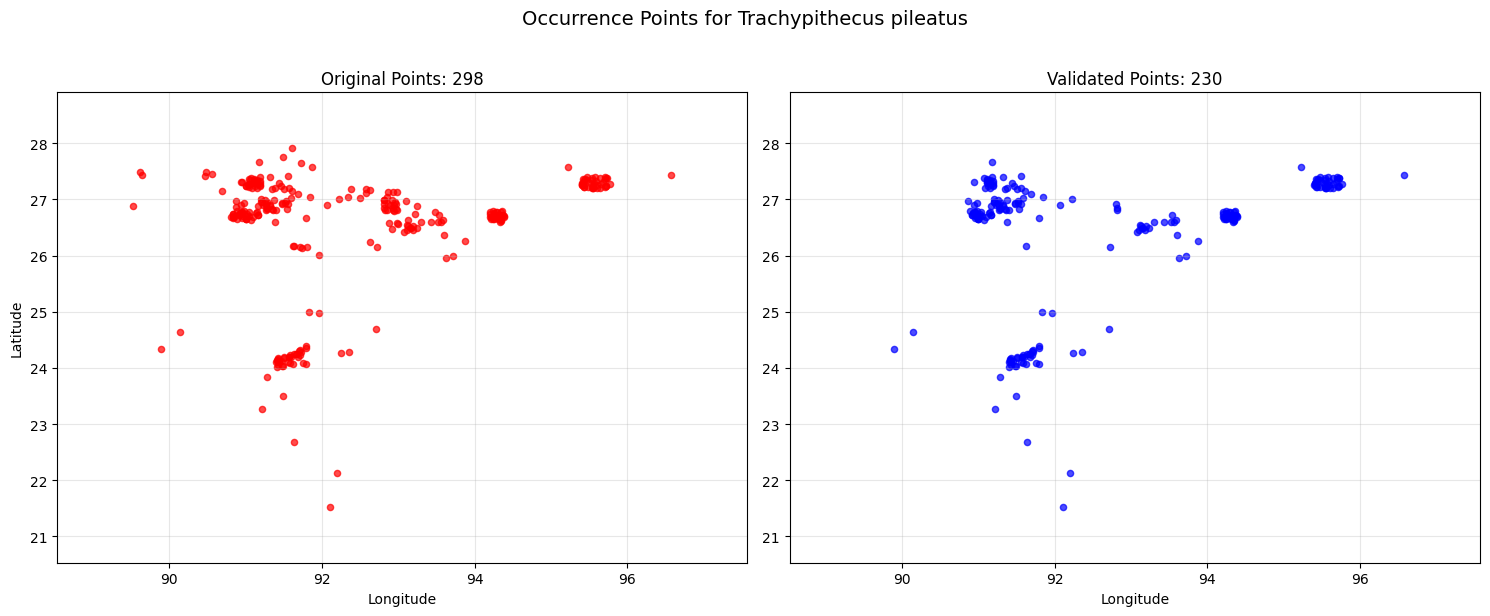

In [51]:


# Step 4: Visualize Original vs Validated Points
def plot_species_comparison(original_df, validated_df, species_name):
    """
    Create a scatter plot comparing original and validated occurrence points for a species.
    """
    # Filter data for the specified species
    orig = original_df[original_df['scientific_name'] == species_name]
    valid = validated_df[validated_df['scientific_name'] == species_name]
    
    # Create figure with two subplots side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Plot original points
    ax1.scatter(orig['longitude'], orig['latitude'], c='red', s=20, alpha=0.7)
    ax1.set_title(f'Original Points: {len(orig)}')
    ax1.set_xlabel('Longitude')
    ax1.set_ylabel('Latitude')
    ax1.grid(True, alpha=0.3)
    
    # Calculate plot limits based on original data
    x_min, x_max = orig['longitude'].min() - 1, orig['longitude'].max() + 1
    y_min, y_max = orig['latitude'].min() - 1, orig['latitude'].max() + 1
    
    # Set the same limits for both subplots
    for ax in [ax1, ax2]:
        ax.set_xlim(x_min, x_max)
        ax.set_ylim(y_min, y_max)
    
    # Plot validated points
    ax2.scatter(valid['longitude'], valid['latitude'], c='blue', s=20, alpha=0.7)
    ax2.set_title(f'Validated Points: {len(valid)}')
    ax2.set_xlabel('Longitude')
    ax2.grid(True, alpha=0.3)
    
    plt.suptitle(f'Occurrence Points for {species_name}', fontsize=14, y=1.02)
    plt.tight_layout()
    
    # Save the plot
    plot_filename = OUTPUT_DIR / f"validation_{species_name.replace(' ', '_')}.png"
    plt.savefig(plot_filename, dpi=150, bbox_inches='tight')
    print(f"Saved validation plot for {species_name} to {plot_filename}")
    
    plt.show()

# Create plots for each species
print("\nGenerating validation plots for each species...")
for species in occurrences_gbif['scientific_name'].unique():
    plot_species_comparison(pd.read_csv(occurrence_csv), validated_occurrences, species)



In [58]:
def load_climate_raster(climate_file, variable_name):
    """
    Load a climate raster (GeoTIFF) into memory with enhanced error handling.
    
    Args:
        climate_file (str): Path to the GeoTIFF file
        variable_name (str): Name of the climate variable
        
    Returns:
        dict: Dictionary containing:
            - data: 2D numpy array of climate data
            - transform: Affine transform for georeferencing
            - crs: Coordinate reference system
            - bounds: Bounding box of the raster
            - variable: Name of the climate variable
            - nodata: NoData value from the raster
            
    Raises:
        FileNotFoundError: If the climate file doesn't exist
        rasterio.errors.RasterioError: For issues reading the raster
    """
    import os
    import numpy as np
    import rasterio
    from rasterio.errors import RasterioError
    
    if not os.path.exists(climate_file):
        raise FileNotFoundError(f"Climate file not found: {climate_file}")
    
    try:
        with rasterio.open(climate_file) as src:
            # Read the first band by default
            data = src.read(1)
            
            # Get metadata
            transform = src.transform
            crs = src.crs
            bounds = src.bounds
            nodata = src.nodata if src.nodata is not None else np.nan
            
            # Print basic info for verification
            print(f"Loaded {variable_name} raster:")
            print(f"  - Shape: {data.shape}")
            print(f"  - Bounds: {bounds}")
            print(f"  - CRS: {crs}")
            print(f"  - NoData value: {nodata}")
            print(f"  - Min value: {np.nanmin(data[data != nodata]):.2f}")
            print(f"  - Max value: {np.nanmax(data[data != nodata]):.2f}")
            
            # Replace NoData values with NaN for easier handling
            if not np.isnan(nodata):
                data = np.where(data == nodata, np.nan, data)
            
            return {
                "data": data,
                "transform": transform,
                "crs": crs,
                "bounds": bounds,
                "variable": variable_name,
                "nodata": nodata
            }
            
    except RasterioError as e:
        print(f"Error reading raster file {climate_file}: {str(e)}")
        raise


def extract_climate_at_points(climate_raster, points_df, lat_col='latitude', lon_col='longitude'):
    """
    Sample climate values at each latitude/longitude in points_df with enhanced validation.
    
    Args:
        climate_raster (dict): Dictionary from load_climate_raster()
        points_df (pd.DataFrame): DataFrame containing point coordinates
        lat_col (str): Name of the latitude column
        lon_col (str): Name of the longitude column
        
    Returns:
        tuple: (values, valid_indices, stats) where:
            - values: Array of climate values at valid points
            - valid_indices: Indices of points that were successfully sampled
            - stats: Dictionary with sampling statistics
    """
    import numpy as np
    from rasterio.transform import rowcol
    
    if not all(col in points_df.columns for col in [lat_col, lon_col]):
        raise ValueError(f"points_df must contain columns: {lat_col}, {lon_col}")
    
    values = []
    valid_indices = []
    out_of_bounds = 0
    nodata_count = 0
    
    # Pre-compute raster properties
    height, width = climate_raster["data"].shape
    transform = climate_raster["transform"]
    data = climate_raster["data"]
    
    for idx, (_, row) in enumerate(points_df.iterrows()):
        lon, lat = row[lon_col], row[lat_col]
        
        try:
            # Convert lat/lon to row/col indices
            row_idx, col_idx = rowcol(transform, lon, lat)
            
            # Check if the point is within raster bounds
            if 0 <= row_idx < height and 0 <= col_idx < width:
                value = data[row_idx, col_idx]
                
                # Check for NoData values
                if not np.isnan(value):
                    values.append(value)
                    valid_indices.append(idx)
                else:
                    nodata_count += 1
            else:
                out_of_bounds += 1
                
        except Exception as e:
            print(f"Error processing point {idx} (lat: {lat}, lon: {lon}): {str(e)}")
            continue
    
    # Calculate statistics
    stats = {
        'total_points': len(points_df),
        'valid_points': len(valid_indices),
        'out_of_bounds': out_of_bounds,
        'nodata_count': nodata_count,
        'success_rate': len(valid_indices) / len(points_df) if len(points_df) > 0 else 0
    }
    
    print("\nSampling Statistics:")
    print(f"  - Total points: {stats['total_points']}")
    print(f"  - Successfully sampled: {stats['valid_points']} ({stats['success_rate']*100:.1f}%)")
    print(f"  - Out of bounds: {stats['out_of_bounds']}")
    print(f"  - NoData values: {stats['nodata_count']}")
    
    return np.array(values), valid_indices, stats


# Example usage:
"""
# Load climate data
climate_data = load_climate_raster('path/to/climate.tif', 'temperature')

# Sample points
values, valid_indices, stats = extract_climate_at_points(
    climate_data, 
    points_df,
    lat_col='latitude',
    lon_col='longitude'
)

# Add sampled values back to original dataframe
points_df['climate_value'] = np.nan
points_df.loc[valid_indices, 'climate_value'] = values
"""

"\n# Load climate data\nclimate_data = load_climate_raster('path/to/climate.tif', 'temperature')\n\n# Sample points\nvalues, valid_indices, stats = extract_climate_at_points(\n    climate_data, \n    points_df,\n    lat_col='latitude',\n    lon_col='longitude'\n)\n\n# Add sampled values back to original dataframe\npoints_df['climate_value'] = np.nan\npoints_df.loc[valid_indices, 'climate_value'] = values\n"

### Step 5: Climate Data Processing

In [52]:
# Step 5: Climate Data Processing
def load_climate_data(climate_dir):
    """Load and process climate data from NetCDF files."""
    print("\nLoading climate data...")
    climate_files = list(Path(climate_dir).glob("*.nc"))
    if not climate_files:
        print(f"No NetCDF files found in {climate_dir}")
        return None
    
    # Load the first file to get the structure
    ds = xr.open_dataset(climate_files[0])
    print(f"Loaded climate data with variables: {list(ds.data_vars)}")
    return ds

def extract_climate_at_points(climate_data, points_df, var_names=None):
    """
    Extract climate values at occurrence points.
    
    Args:
        climate_data: xarray Dataset with climate data
        points_df: DataFrame with 'latitude' and 'longitude' columns
        var_names: List of variable names to extract (if None, extract all)
    
    Returns:
        DataFrame with climate values for each point
    """
    if var_names is None:
        var_names = list(climate_data.data_vars)
    
    # Create a copy of the points dataframe
    result_df = points_df.copy()
    
    # Convert points to xarray compatible format
    lats = xr.DataArray(points_df['latitude'].values, dims='point')
    lons = xr.DataArray(points_df['longitude'].values, dims='point')
    
    # Extract values for each variable
    for var in var_names:
        if var in climate_data:
            # Use nearest neighbor interpolation
            values = climate_data[var].sel(
                latitude=lats,
                longitude=lons,
                method='nearest'
            )
            result_df[var] = values.values
    
    return result_df





In [53]:
# Step 6: Climate Time Series Analysis
def create_climate_time_series(climate_dir, time_periods, variables, points_df):
    """
    Create a time series of climate variables for the given points.
    
    Args:
        climate_dir: Directory containing climate data files
        time_periods: List of time periods (file name patterns)
        variables: List of climate variables to include
        points_df: DataFrame with occurrence points
    
    Returns:
        DataFrame with mean climate values for each time period
    """
    results = []
    
    for period in time_periods:
        # Find the climate file for this time period
        pattern = f"*{period}*.nc"
        try:
            file_path = next(Path(climate_dir).glob(pattern))
        except StopIteration:
            print(f"No file found matching pattern: {pattern}")
            continue
            
        print(f"Processing {file_path.name}...")
        
        # Load the climate data
        ds = xr.open_dataset(file_path)
        
        # Extract values at points
        climate_values = extract_climate_at_points(ds, points_df, variables)
        
        # Calculate mean values across all points
        mean_values = climate_values[variables].mean().to_dict()
        mean_values['time_ka'] = float(period)
        
        results.append(mean_values)
    
    return pd.DataFrame(results)





###  Step 7: Plot Climate Time Series

In [59]:
def create_climate_time_series(period_folders, variables, occurrences_df):
    """
    Aggregate climate values for each time period across all occurrence points.
    
    Args:
        period_folders (dict): Maps time periods (ka) to folder paths containing climate data
        variables (list): List of climate variables to extract (e.g., ['bio1', 'bio12'])
        occurrences_df (pd.DataFrame): DataFrame containing occurrence points with 'latitude' and 'longitude' columns
        
    Returns:
        pd.DataFrame: Time series data with climate statistics for each period
    """
    import pandas as pd
    import numpy as np
    from pathlib import Path
    from tqdm import tqdm
    import warnings
    warnings.filterwarnings('ignore', message='invalid value encountered in scalar divide')
    
    time_series_data = []
    total_periods = len(period_folders)
    
    print(f"Processing {total_periods} time periods with {len(variables)} variables each...")
    
    for period, folder in tqdm(period_folders.items(), desc="Processing time periods"):
        period_data = {"time_period": period}
        folder = Path(folder) if folder else None

        if folder is None or not folder.exists():
            print(f"\nWarning: folder for {period}ka not found ({folder})")
            time_series_data.append(period_data)
            continue

        period_results = {}
        
        for var in variables:
            # Handle both 'bio1' and 'bio_1' naming conventions
            if var.startswith('bio'):
                var_num = var[3:]  # Extract number from 'bio1'
                tif_name = f"bio_{var_num}.tif"
            else:
                tif_name = f"{var}.tif"
                
            file_path = folder / tif_name

            if not file_path.exists():
                # Try alternative naming convention
                alt_tif_name = f"{var}.tif" if var.startswith('bio') else f"bio_{var}.tif"
                file_path = folder / alt_tif_name
                
                if not file_path.exists():
                    print(f"\nWarning: raster {tif_name} not found in {folder}")
                    continue

            try:
                # Load and process the raster
                raster = load_climate_raster(str(file_path), var)
                values, valid_indices, stats = extract_climate_at_points(raster, occurrences_df)
                
                if len(values) > 0:
                    # Calculate statistics
                    period_data.update({
                        f"{var}_mean": np.nanmean(values),
                        f"{var}_std": np.nanstd(values),
                        f"{var}_min": np.nanmin(values),
                        f"{var}_max": np.nanmax(values),
                        f"{var}_n": len(values)
                    })
                    print(f"  - {var}: {len(values)} valid points")
                else:
                    print(f"\nWarning: no valid samples for {var} at {period}ka")
                    
            except Exception as e:
                print(f"\nError processing {var} at {period}ka: {str(e)}")
                continue

        time_series_data.append(period_data)

    # Create DataFrame and clean up
    df = pd.DataFrame(time_series_data)
    
    # Sort by time period (most recent first)
    df = df.sort_values('time_period', ascending=False)
    
    # Add years column
    df['time_years'] = df['time_period'] * 1000
    
    return df

# Configuration
period_folders = {
    0: DATA_DIR / "paleoclim" / "LH_v1_2_5m",  # Late Holocene
    6: DATA_DIR / "paleoclim" / "MH_v1_2_5m",   # Mid Holocene
    12: DATA_DIR / "paleoclim" / "EH_v1_2_5m",  # Early Holocene
    21: DATA_DIR / "paleoclim" / "LGM_v1_2_5m", # Last Glacial Maximum
}

# Get variables from config or use defaults
variables = config.get("climate_data", {}).get("variables", ["bio1", "bio12"])

# Process the data if occurrences exist
if 'occurrences_gbif' in locals() and not occurrences_gbif.empty:
    print(f"Processing climate data for {len(occurrences_gbif)} occurrence points...")
    
    # Run the time series creation
    climate_series = create_climate_time_series(period_folders, variables, occurrences_gbif)
    
    # Save results
    results_csv = OUTPUT_DIR / "climate_time_series.csv"
    climate_series.to_csv(results_csv, index=False)
    
    # Print summary
    print(f"\nClimate time series created with {len(climate_series)} time periods")
    print(f"Results saved to: {results_csv}")
    
    # Display the first few rows
    display(climate_series.head())
    
    # Basic validation
    print("\nSummary statistics:")
    print(climate_series.describe())
    
else:
    print("Cannot create climate time series. Occurrence data is missing or empty.")
    print("Please run the occurrence data processing steps first.")

Processing climate data for 1118 occurrence points...
Processing 4 time periods with 2 variables each...


Processing time periods:   0%|          | 0/4 [00:00<?, ?it/s]

Loaded bio1 raster:
  - Shape: (4176, 8640)
  - Bounds: BoundingBox(left=-180.00013888885002, bottom=-90.00013888884999, right=179.99985967115003, top=83.99986041515004)
  - CRS: EPSG:4326
  - NoData value: -32768.0
  - Min value: -526.00
  - Max value: 314.00

Sampling Statistics:
  - Total points: 1118
  - Successfully sampled: 1118 (100.0%)
  - Out of bounds: 0
  - NoData values: 0
  - bio1: 1118 valid points
Loaded bio12 raster:
  - Shape: (4176, 8640)
  - Bounds: BoundingBox(left=-180.00013888885002, bottom=-90.00013888884999, right=179.99985967115003, top=83.99986041515004)
  - CRS: EPSG:4326
  - NoData value: 65535.0
  - Min value: 0.00
  - Max value: 11010.00


Processing time periods:  25%|██▌       | 1/4 [00:01<00:03,  1.10s/it]


Sampling Statistics:
  - Total points: 1118
  - Successfully sampled: 1118 (100.0%)
  - Out of bounds: 0
  - NoData values: 0
  - bio12: 1118 valid points
Loaded bio1 raster:
  - Shape: (4285, 8640)
  - Bounds: BoundingBox(left=-180.0, bottom=-90.0000000000002, right=180.00000000000028, top=88.5416666666666)
  - CRS: EPSG:4326
  - NoData value: -32768.0
  - Min value: -533.00
  - Max value: 302.00

Sampling Statistics:
  - Total points: 1118
  - Successfully sampled: 1118 (100.0%)
  - Out of bounds: 0
  - NoData values: 0
  - bio1: 1118 valid points
Loaded bio12 raster:
  - Shape: (4285, 8640)
  - Bounds: BoundingBox(left=-180.0, bottom=-90.0000000000002, right=180.00000000000028, top=88.5416666666666)
  - CRS: EPSG:4326
  - NoData value: 65535.0
  - Min value: 0.00
  - Max value: 11039.00


Processing time periods:  50%|█████     | 2/4 [00:02<00:02,  1.01s/it]


Sampling Statistics:
  - Total points: 1118
  - Successfully sampled: 1118 (100.0%)
  - Out of bounds: 0
  - NoData values: 0
  - bio12: 1118 valid points
Loaded bio1 raster:
  - Shape: (4285, 8640)
  - Bounds: BoundingBox(left=-180.0, bottom=-90.0000000000002, right=180.00000000000028, top=88.5416666666666)
  - CRS: EPSG:4326
  - NoData value: -32768.0
  - Min value: -553.00
  - Max value: 301.00

Sampling Statistics:
  - Total points: 1118
  - Successfully sampled: 1118 (100.0%)
  - Out of bounds: 0
  - NoData values: 0
  - bio1: 1118 valid points
Loaded bio12 raster:
  - Shape: (4285, 8640)
  - Bounds: BoundingBox(left=-180.0, bottom=-90.0000000000002, right=180.00000000000028, top=88.5416666666666)
  - CRS: EPSG:4326
  - NoData value: 65535.0
  - Min value: 0.00
  - Max value: 11103.00


Processing time periods:  75%|███████▌  | 3/4 [00:02<00:00,  1.02it/s]


Sampling Statistics:
  - Total points: 1118
  - Successfully sampled: 1118 (100.0%)
  - Out of bounds: 0
  - NoData values: 0
  - bio12: 1118 valid points
Loaded bio1 raster:
  - Shape: (4320, 8640)
  - Bounds: BoundingBox(left=-179.99999999995, bottom=-89.99999999995002, right=180.00000000005028, top=90.00000000005012)
  - CRS: EPSG:4326
  - NoData value: -32768.0
  - Min value: -800.00
  - Max value: 281.00

Sampling Statistics:
  - Total points: 1118
  - Successfully sampled: 1118 (100.0%)
  - Out of bounds: 0
  - NoData values: 0
  - bio1: 1118 valid points
Loaded bio12 raster:
  - Shape: (4320, 8640)
  - Bounds: BoundingBox(left=-179.99999999995, bottom=-89.99999999995002, right=180.00000000005028, top=90.00000000005012)
  - CRS: EPSG:4326
  - NoData value: 65535.0
  - Min value: 0.00
  - Max value: 3276.00


Processing time periods: 100%|██████████| 4/4 [00:04<00:00,  1.00s/it]


Sampling Statistics:
  - Total points: 1118
  - Successfully sampled: 1118 (100.0%)
  - Out of bounds: 0
  - NoData values: 0
  - bio12: 1118 valid points

Climate time series created with 4 time periods
Results saved to: outputs/climate_time_series.csv


,time_period,bio1_mean,bio1_std,bio1_min,bio1_max,bio1_n,bio12_mean,bio12_std,bio12_min,bio12_max,bio12_n,time_years
3,21,161.843470,57.069032,-84.0,231.0,1118,2009.593918,626.385338,452.0,3276.0,1118,21000
2,12,180.274597,60.313127,-47.0,264.0,1118,2267.210197,794.757738,487.0,5740.0,1118,12000
1,6,187.472272,58.402730,-32.0,265.0,1118,2244.892665,790.837824,522.0,5790.0,1118,6000
0,0,196.254025,56.892469,-15.0,269.0,1118,2229.045617,797.933515,493.0,5853.0,1118,0



Summary statistics:
       time_period   bio1_mean   bio1_std   bio1_min    bio1_max  bio1_n  \
count     4.000000    4.000000   4.000000   4.000000    4.000000     4.0   
mean      9.750000  181.461091  58.169340 -44.500000  257.250000  1118.0   
std       8.958236   14.619895   1.580229  29.399546   17.632829     0.0   
min       0.000000  161.843470  56.892469 -84.000000  231.000000  1118.0   
25%       4.500000  175.666816  57.024891 -56.250000  255.750000  1118.0   
50%       9.000000  183.873435  57.735881 -39.500000  264.500000  1118.0   
75%      14.250000  189.667710  58.880330 -27.750000  266.000000  1118.0   
max      21.000000  196.254025  60.313127 -15.000000  269.000000  1118.0   

        bio12_mean   bio12_std   bio12_min    bio12_max  bio12_n    time_years  
count     4.000000    4.000000    4.000000     4.000000      4.0      4.000000  
mean   2187.685599  752.478604  488.500000  5164.750000   1118.0   9750.000000  
std     119.755457   84.112258   28.734416  1260.01

Saved static plot: outputs/climate_time_series.png


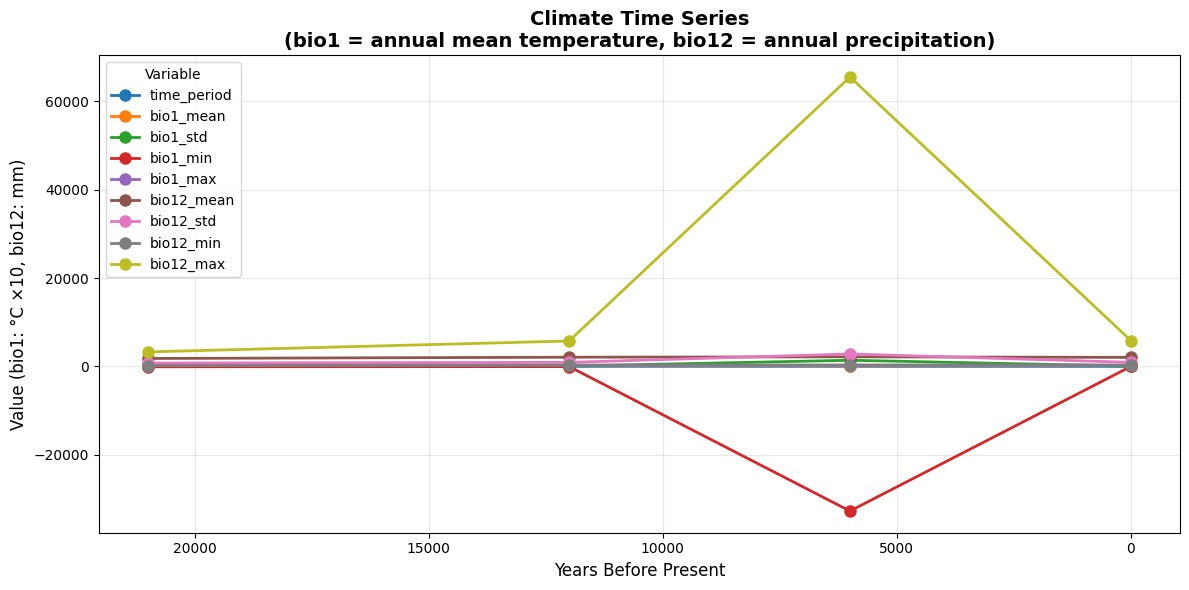


Climate data processing complete!


In [55]:
import plotly.express as px

def plot_climate_time_series(climate_df, output_file=None):
    """
    Plot climate variables over time using Matplotlib (static) and Plotly (interactive).
    bio1 = annual mean temperature (°C ×10), bio12 = annual precipitation (mm).
    """
    if climate_df is None or climate_df.empty:
        print("No climate data available to plot.")
        return None

    # Get the list of variables (excluding time_years)
    variables = [col for col in climate_df.columns if col != 'time_years']
    
    # --- Static Matplotlib plot ---
    plt.figure(figsize=(12, 6))

    for var in variables:
        plt.plot(
            climate_df["time_years"],
            climate_df[var],
            marker="o",
            label=f"{var}",
            linewidth=2,
            markersize=8,
        )

    plt.xlabel("Years Before Present", fontsize=12)
    plt.ylabel("Value (bio1: °C ×10, bio12: mm)", fontsize=12)
    plt.title(
        "Climate Time Series\n(bio1 = annual mean temperature, bio12 = annual precipitation)",
        fontsize=14,
        fontweight="bold",
    )
    plt.legend(title="Variable")
    plt.grid(True, alpha=0.3)
    plt.gca().invert_xaxis()  # Invert x-axis to show older to newer
    plt.tight_layout()

    if output_file:
        plt.savefig(output_file, dpi=300, bbox_inches="tight")
        print(f"Saved static plot: {output_file}")

    plt.show()

    # --- Interactive Plotly plot ---
    if not variables:
        print("No variables available to plot interactively.")
        return None
        
    # Melt the dataframe for Plotly
    melted = climate_df.melt(
        id_vars="time_years", 
        var_name="Variable", 
        value_name="Value"
    )
    
    # Create interactive plot
    interactive_fig = px.line(
        melted,
        x="time_years",
        y="Value",
        color="Variable",
        markers=True,
        title="Interactive Climate Time Series",
        labels={
            "time_years": "Years Before Present",
            "Value": "Value (bio1: °C ×10, bio12: mm)",
        },
    )
    
    # Reverse x-axis to show older to newer
    interactive_fig.update_layout(xaxis_autorange="reversed")
    interactive_fig.show()

    return interactive_fig

# Check if results file exists and plot
results_csv = OUTPUT_DIR / "climate_time_series.csv"
if results_csv.exists():
    climate_df = pd.read_csv(results_csv)
    plot_climate_time_series(climate_df, OUTPUT_DIR / "climate_time_series.png")
    print("\nClimate data processing complete!")
else:
    print("Climate time series not found. Run the previous steps first.")